# Setup

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [2]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [3]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

## Get all cells info

In [4]:
nodefiles = get_cell_filepaths(dirpath)

In [5]:
cell_type = {}
not_typed = []
for x in nodefiles.keys():
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[x]='none'
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        

the following cells are not typed in the main network
['481507678', '561579694', '561641072', '561641580', '561702549', '568432245']


In [9]:
set([k for k,v in cell_type.items() if v in 'sg'])

{'299589324'}

In [73]:
soma_diam = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    if 'soma' in cell.cell_data['end_points'].keys():
        soma_anno = cell.cell_data['end_points']['soma']
        xpts = [p[0] for p in soma_anno]
        zpts = [p[2] for p in soma_anno]

        soma_diam[x] = np.mean([int((np.max(xpts)-np.min(xpts))/16),int((np.max(zpts)-np.min(zpts))/16)])
    
    if 'soma' not in cell.cell_data['end_points'].keys():
        soma_diam[x] = np.NaN


<AxesSubplot:xlabel='type', ylabel='size'>

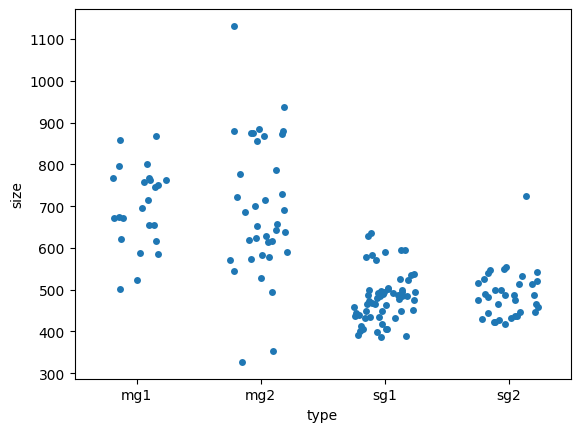

In [69]:
df = pd.DataFrame.from_dict(soma_diam,orient='index',columns=['size']).reset_index()

type_list=[]
for k in df['index']:
    type_list.append(cell_type[k])

df['type'] = type_list

network_types = ['mg1','mg2','sg1','sg2']
df = df[df['type'].isin(network_types)]

sns.stripplot(data=df, y="size", x="type",jitter=0.25)

## Get all segments

In [74]:
# Create a base_segments dictionary of all reconstructed cells 

base_segments = {}
for x in nodes:
    # if cell_type[x] in network_types: # if do this, you can't check if the post-syn segments exist as a reconstruction
    cell = ecrest(settings_dict,filepath = nodefiles[x])#,launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']
    
    try:
        assert cell.cell_data['metadata']['main_seg']['base'] == x
    except:
        print(x,cell.cell_data['metadata']['main_seg']['base'])

## Cell structure labeling checks

In [ ]:
print('need labeling for:')

for x,segs in base_segments.items():
    if (len(segs['unknown']) == len([s for k,v in segs.items() for s in v])) & (cell_type[x] in ['lf','lg']):
        print(f'{x} {cell_type[x]}')

## Build Graph

In [75]:
network_types = set([v for v in cell_type.values()])#['mg1','mg2','lg','lf','sg1','sg2','sgx','grc','aff']

In [76]:
synanno_type = 'pre-synaptic'
vx_sizes = [16, 16, 30]

## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []

with tqdm(total=len(nodes)) as pbar:
    for x_pre in nodes:
        pbar.update(1)
        if cell_type[x_pre] in network_types:
            
            # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
            pre = ecrest(settings_dict,filepath = nodefiles[x_pre])#,launch_viewer=False)
            if pre.cell_data['end_points'][synanno_type] != []:
                # for each synapse
                for syn_ in pre.cell_data['end_points'][synanno_type]:
                    try:
                        post_seg = syn_[3]
                        syn_ = array([int(syn_[i]/vx_sizes[i]) for i in range(3)])

                        # go through each other nodes
                        for x_post in nodes:
                            if cell_type[x_post] in network_types:
                                post = base_segments[x_post] 
                                for k,v in post.items():
                                    for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids
                                        if post_seg == v_: 
                                            # add edge to the graph between current node and matching node
                                            
                                            edge_list.append([x_pre,x_post,k,syn_[0],syn_[1],syn_[2]])
                                            

                    except IndexError as msg:
                        cellid = x_pre
                        print(msg, f'for cell {cellid} synapse at {array([int(syn_[i]/vx_sizes[i]) for i in range(3)])} has no segment id')

            else:
                continue


100%|███████████████████████████████████████| 1919/1919 [09:11<00:00,  3.48it/s]


### Specific cell(S)

In [66]:
edge_list = []
cell_list = ['301787806']
synanno_type = 'pre-synaptic'

for x_pre in cell_list:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre])
    for syn_ in pre.cell_data['end_points'][synanno_type]:
        try:
            post_seg = syn_[3]
            syn_ = array([int(syn_[i]/vx_sizes[i]) for i in range(3)])

            # go through each other nodes
            for x_post in nodes:
                if cell_type[x_post] in network_types:
                    post = base_segments[x_post] 
                    for k,v in post.items():
                        for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids
                            if post_seg == v_: 
                                # add edge to the graph between current node and matching node

                                edge_list.append([x_pre,x_post,k,syn_[0],syn_[1],syn_[2]])

        except IndexError as msg:
            cellid = x_pre
            print(msg, f'for cell {cellid} synapse at {array([int(syn_[i]/vx_sizes[i]) for i in range(3)])} has no segment id')




### Synapses dataframe

In [77]:
df_syn = pd.DataFrame(edge_list,columns = ['pre','post','structure','x','y','z'])

for i,r in df_syn.iterrows():
    df_syn.loc[i,'pre_type']=cell_type[df_syn.loc[i,'pre']]
    df_syn.loc[i,'post_type']=cell_type[df_syn.loc[i,'post']]

#### If want to peak at df_Edges

In [68]:
df_edges = df_syn[['pre','post','structure','pre_type','post_type']].value_counts().reset_index(name='weight')
for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_diam']=soma_diam[str(df_edges.loc[i,'pre'])]
    df_edges.loc[i,'post_diam']=soma_diam[str(df_edges.loc[i,'post'])]

df_edges.loc[:,'diam_diff'] = (df_edges['post_diam']-df_edges['pre_diam'])/df_edges['pre_diam']

# df_edges

In [44]:
# df_edges

In [69]:
df_edges.post_type.unique()

array(['sg2', 'mg2', 'uk', 'fov', 'sgx2', 'grc-d', 'lg'], dtype=object)

In [70]:
focal_cell_id = '301787806'
display(df_syn[df_syn['pre']==focal_cell_id][['post','post_type']].value_counts().reset_index(
    name='weight')['post_type'].value_counts().reset_index(name='ncells'))

,index,ncells
0,grc-d,16
1,sg2,14
2,mg2,13
3,uk,3
4,fov,2
5,lg,2
6,sgx2,1


#### Ignore cell structure

If just want different cell pairs to count as unique (ignore morphology), use the following cell

In [46]:
# df_syn.drop(['structure'],axis=1, inplace=True)


#### save df_syn

In [78]:
savepath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/graphs/')

df_syn.to_csv(savepath / 'df_presyn.csv')